# Setting Up

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
OPEN_API_KEY = os.getenv('OPEN_API_KEY')

LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
LANGSMITH_PROJECT = os.getenv('LANGSMITH_PROJECT')
LANGSMITH_ENDPOINT = os.getenv('LANGSMITH_ENDPOINT')

TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
from tavily import TavilyClient
from pprint import pprint
tavily = TavilyClient(TAVILY_API_KEY)

# Agents:

## Supervisor Agent
- Task: Supervise the research agent and ensure the output is relevant and sufficient to generate a chart.
- Input: A user query
- Process: 
    - Gets the summary and reasoning from the research agent
    - Evaluates the summary and reasoning
    - Decides if the content is relevant and sufficient to generate a chart.
    - If the content is not relevant or sufficient, it will call the research agent again with a new user query.
    - If the content is relevant and sufficient, it will go to the chart_agent to generate a chart with a brief chart description.
- Output:
    - A chart
    - Chart description

## Research Agent
- Task: Research the web for information that is relevant and sufficient to generate a chart.
- Input: A user query
- Process: 
    - Uses tools (web search tool and web scraping tool) to research the web for information
    - Passes the summary and reasoning to the supervisor agent
- Output:
    - A summary of the relevant information extracted from the scraped URLs.
    - Reasoning for the output why the content is relevant and sufficient to generate a chart.


## Chart Agent
- Task: Generate a chart based on the chart summary.
- Input: A summary of the relevant information extracted from the scraped URLs.
- Process: 
    - Uses a tool to generate code based on input summary to generate a chart - tool name: code_generator_tool
    - Passes the code to the python repl tool to generate a chart - tool name: python_repl_tool
    - Passes the chart to the supervisor agent for review
- Output:
    - A Chart

# 1. Research Agent

Tools to make:
- Web Search Tool (Researcher)
    - Task: Researches the web for information.
    - Input: A user query
    - Process: 
        - Gets the relevant keywords from query to perform a search
        - Uses keyword and performs a search on the web
        - Gets a list of URLs and returns the list (output)
    - Output: A list of URLs

- Web Scraping Tool (Researcher)
    - Task: Scrapes websites from a list of URLs and returns a coherent summary of the content relevant to the user's query.
    - Input: A list of URLs
    - Process: 
        - Iterates over each URL in the provided list of URLs
        - Performs a GET request to the URL
        - Parses the HTML content of the page
        - Combines the scraped content into a coherent summary using a language model (LLM).
    - Output: A string containing a summary of the relevant information extracted from the scraped URLs.

In [5]:
from pydantic import BaseModel, Field

from typing import TypedDict, List
from typing import Annotated
from operator import add
from typing import Literal

class ResearchOutput(BaseModel):
    next_action: Literal["web_search_tool", "web_scraping_tool", "DONE"] = Field(description="The next action to perform. Can be web_search_tool, web_scraping_tool, or DONE if the content is sufficient to generate a chart.")
    reasoning: str = Field(description="Reasoning for the output, explaining which tool should be used next and why the content is relevant and sufficient to generate a chart based on the summary received.")

class ChartOutput(BaseModel):
    next_action: Literal["code_generator_tool", "python_repl_tool", "DONE"] = Field(description="The next action to perform. Can be code_generator_tool, python_repl_tool, or DONE if the chart is good enough to be used.")
    reasoning: str = Field(description="Reasoning for the output, explaining which tool should be used next and why the chart is good enough to be used.")

class SupervisorOutput(BaseModel):
    next_action: Literal["research_agent", "chart_agent", "DONE"] = Field(description="The next action to perform. Can be research_agent, chart_agent, or DONE if the task is complete.")
    reasoning: str = Field(description="Reasoning for the output, explaining why the task is complete or not.")

class AgentState(TypedDict):
    query: str
    actions_performed: Annotated[List[str], add]
    research_agent_output: ResearchOutput
    urls: List[str]
    combined_content: str
    keywords_used: Annotated[List[str], add]
    code: str
    chart: str
    chart_agent_output: ChartOutput
    supervisor_output: SupervisorOutput
    

In [6]:
def web_search_tool(state: AgentState):
    """Search the web for information and return URLs"""  

    def extract_keywords(user_query):
        """Extract relevant keywords from a complex user query using LLM"""

        prompt = """
        Extract a unique search term I can use to search the web for numerical data that can be used for chart generation from this query.

        Instructions:
        - The search keywords should be specific and relevant to the query provided.
        - Focus on terms that are likely to yield quantitative data, such as statistics, figures, or metrics.
        - Ensure that the keywords can lead to sources that provide numerical information suitable for creating charts or graphs.
        - The search keywords should consist maximum of 4 words.
        - The generated keywords should be unique and not already included in the existing list of keywords.

        Query: {user_query}
        Keywords used so far: {keywords_used}
        Search term:
        """
        keywords_used = state.get("keywords_used",[""])
        response = llm.invoke(prompt.format(user_query=user_query, keywords_used=keywords_used))
        return response.content

    keywords = extract_keywords(state['query']) 
    response = tavily.search(keywords)

    urls = [result['url'] for result in response['results'][:3]]

    return {"urls": urls, "actions_performed": [f"Used the keyword: {keywords} to search the web for information. Received {', '.join(urls)} URLs."], "keywords_used": [keywords]}

In [7]:
from bs4 import BeautifulSoup
import requests

def web_scraping_tool(state: AgentState):
    """Scrape websites from a list of URLs and return a dictionary with URL and content"""
    results = {}
    # Iterate over each URL in the provided list of URLs
    for url in state['urls']:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')
        results[url] = soup.get_text()

    def combine_scraped_content(scraped_data):
        """This function takes a dictionary of scraped data, where each key is a URL and each value is the corresponding content.
        It constructs a prompt for a language model (LLM) to generate a coherent summary of the content relevant to the user's query.
        
        The function initializes a prompt string that instructs the LLM to combine the content. It then iterates over the scraped data,
        appending each URL and its content to the prompt. After constructing the complete prompt, it invokes the LLM with this prompt
        and returns the generated summary as a string."""
        
        prompt = """
        Combine the following content into a coherent summary, relevant for the user query.

        Instructions:
        - If there are any numerical data, make sure to include it in the summary.
        - This numerical data from the summary will be later used to generate a chart.
        """

        for url, content in scraped_data.items():
            prompt += f"URL: {url}\nContent: {content}\n\n"
        
        response = llm.invoke(prompt)
        return response.content

    # Call the combine function and return the combined content
    combined_content = combine_scraped_content(results)
    return {"combined_content": combined_content, "actions_performed": [f"Scraped the content from the URLs: {', '.join(results.keys())} and combined it into a coherent summary."]}

In [8]:
from langchain_core.messages import HumanMessage, SystemMessage

def research_agent(state: AgentState):
    system_prompt = """
    You are an expert researcher. You are given a user query and you need to use tools to research the web for information that is reliable and sufficient to generate a chart.
    
    You need to use the following tools to research the web for information:

    1. Web Search Tool: This tool does the following:
        - Task: Researches the web for information.
        - Input: A user query
        - Process: 
            - Gets the relevant keywords from query to perform a search
            - Uses keyword and performs a search on the web
            - Gets a list of URLs and returns the list (output)
        - Output: A list of URLs
        - Decision: Use this tool ONLY when you need to gather initial information based on the user query OR when the summary from web scraping is insufficient to generate a chart.

    2. Web Scraping Tool: This tool does the following:
        - Task: Scrapes websites from a list of URLs and returns a coherent summary of the content relevant to the user's query.
        - Input: A list of URLs (received from the web_search_tool)
        - Process: 
            - Iterates over each URL in the provided list of URLs
            - Performs a GET request to the URL
            - Parses the HTML content of the page
            - Combines the scraped content into a coherent summary using a language model (LLM).
        - Output: A string containing a summary of the relevant information extracted from the scraped URLs.
        - Decision: Use this tool IMMEDIATELY after receiving URLs from the web search tool to extract relevant content.

    3. If the content is sufficient to generate a chart, you must respond with DONE as the next action and provide reasoning as output.

    Your inputs will be:
    - A user query
    - Actions performed so far
    - A list of URLs obtained from the web_search_tool
    - A summary of the relevant information extracted from the web_scraping_tool. If no URLs have been scraped yet, the summary will be an empty string.

    Your output will be:
    - Next action to perform: Can be web_search, web_scraping, or DONE if the content is sufficient to generate a chart.
    - Reasoning for the output, explaining which tool should be used next and why the content is relevant and sufficient to generate a chart based on the summary received.

    Instructions:
    - You will receive a user query and a summary of the relevant information extracted from the scraped URLs.
    - For your FIRST action, you MUST use the web_search_tool to get a list of URLs based on the user query.
    - After receiving URLs from web_search_tool, you MUST ALWAYS use the web_scraping_tool next to process those URLs.
    - After receiving the summary from web_scraping_tool, evaluate if the content is sufficient to generate a chart.
    - If the summary is sufficient to generate a meaningful chart, respond with DONE.
    - ONLY return to web_search_tool if the summary from web_scraping_tool is inadequate or insufficient for generating a chart.
    - DO NOT repeatedly call web_search_tool if you already have URLs that haven't been scraped yet.

    IMPORTANT: 
    - If this is your first action and no actions have been performed yet, ALWAYS choose web_search_tool.
    - If URLs have been obtained but not yet scraped (check the actions_performed), ALWAYS choose web_scraping_tool next.
    - Only evaluate the sufficiency of information AFTER receiving a summary from web_scraping_tool.
    """
    human_prompt = """
    User Query: {query}
    Actions performed so far: {actions_performed}
    Summary of the relevant information extracted from the scraped URLs: {summary}
    """
    system_message = SystemMessage(content=system_prompt)
    query = state['query']
    actions_performed = state.get('actions_performed', [])
    summary = state.get('combined_content', '')

    human_message = HumanMessage(content=human_prompt.format(query=query, summary=summary, actions_performed=actions_performed))
    

    research_prompt = [system_message, human_message]
    response = llm.with_structured_output(ResearchOutput).invoke(research_prompt)
    return {"research_agent_output": response, "actions_performed": [f"Research agent performed the action: {response.next_action}"]}
    

In [9]:
def end_agent(state: AgentState):
    return state

In [10]:
from langgraph.graph import StateGraph, START, END

def after_research_agent_router(state: AgentState):
    next_action = state['research_agent_output'].next_action
    if next_action == 'DONE':
        return "supervisor_agent"
    
    return next_action
    

# 2. Chart Agent

Tools to make:
- Code Generator Tool (Code Generator)
    - Task: Generates code based on the input summary to generate a relevantchart.
    - Input: A summary of the relevant information extracted from the scraped URLs (received from the research agent, using state['combined_content']).
    - Process: 
        - Uses a language model (LLM) to generate code based on the input summary to generate a chart.
    - Output: A string containing the code to generate a chart.
- Python REPL Tool (Python Interpreter)
    - Task: Executes the generated code to generate a chart.
    - Input: The generated code (received from the code_generator_tool).
    - Process: 
        - Executes and runs the generated code to generate a chart.
    - Output: The output of the generated code(which is the chart)
- Chart Description Tool (Chart Description Generator)
    - Task: Generates a description of the chart based on the chart received from the python_repl_tool.
    - Input: The chart (received from the python_repl_tool).
    - Process: 
        - Uses a language model (LLM) to generate a description of the chart.
    - Output: A string containing the description of the chart.

In [12]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL
import matplotlib as plt
import seaborn as sns

In [13]:
def code_generator_tool(state: AgentState):
    """Generate Python code to create a visually appealing and informative chart based on the provided summary, ensuring to include appropriate titles, labels, and legends for clarity."""
    
    prompt ="""
    Generate Python code to create a visually appealing and informative chart based on the provided summary.
    Instructions:
    - Choose the most appropriate chart type for the data (bar chart, line chart, pie chart, scatter plot, etc.)
    - Use either matplotlib or seaborn to create a visually stunning visualization
    - Include appropriate titles, labels, legends, and annotations
    - Use an aesthetically pleasing color palette
    - Add data points, trend lines, or other visual elements that enhance understanding
    - Format numbers and percentages properly
    - Include a clean layout with proper spacing
    - Do not provide anything else apart from the code
    - Only return the code, no descriptions
    - The code should be able to be executed directly
    Summary: {summary}

    """
    code = llm.invoke(prompt.format(summary=state['combined_content']))
    return  {'code': code.content, 'actions_performed': [f"Code generator tool performed the action and generated the code: {code.content}"]}

In [14]:
def python_repl_tool(state: AgentState):
    """Execute Python code and return the output"""
    python_repl = PythonREPL()
    result = python_repl.run(state['code'])
    return {'chart': result, 'actions_performed': [f"Python repl tool executed the code and generated the chart."]}

In [15]:
def chart_agent(state: AgentState):
    system_prompt = """
    You are an expert chart generator. You are given a summary of the relevant information extracted from the scraped URLs and you need to generate a chart based on that summary.
    
    You need to use the following tools to generate a chart:

    1. Code Generator Tool: This tool does the following:
        - Task: Generates code based on the input summary to generate a relevant chart.
        - Input: A summary of the relevant information extracted from the scraped URLs (received from the research agent, using state['combined_content']).
        - Process: 
            - Uses a language model (LLM) to generate code based on the input summary to generate a chart.
        - Output: A string containing the code to generate a chart.

    2. Python REPL Tool: This tool does the following:
        - Task: Executes the generated code to generate a chart.
        - Input: The generated code (received from the code_generator_tool).
        - Process: 
            - Executes and runs the generated code to generate a chart.
        - Output: The output of the generated code(which is the chart)

    3. If the chart is generated, you must respond with DONE as the next action and provide reasoning as output.

    Your inputs will be:
    - A summary of the relevant information extracted from the scraped URLs (received from the research agent, using state['combined_content']).
    - Actions performed so far
    - A chart (received from the python_repl_tool)
    Your output will be:
    - Next action to perform: Can be code_generator, python_repl, or DONE if the chart is good enough to be used.
    - Reasoning for the output, explaining which tool should be used next and why the chart is good enough to be used.

    Instructions:
    - You will receive a summary of the relevant information extracted from the scraped URLs and a chart.
    - For your FIRST action, you MUST use the code_generator_tool to generate code based on the summary to generate a chart.
    - After receiving the code from the code_generator_tool, you MUST use the python_repl_tool to execute the code to generate a chart.
    - After receiving the chart from the python_repl_tool, you MUST use the chart_description_tool to generate a good description of the chart.
    - If the chart is good enough to be used, respond with DONE.
    - ONLY return to code_generator_tool if the chart from python_repl_tool is not satisfactory.
    - DO NOT repeatedly call code_generator_tool if you already have a chart.
    - IMPORTANT: If the chart is generated once, you must respond with DONE.

    """
    human_prompt = """
    Summary of the relevant information extracted from the scraped URLs: {summary}
    Actions performed so far: {actions_performed}
    Chart: {chart}
    """
    system_message = SystemMessage(content=system_prompt)
    summary = state.get('combined_content', '')
    actions_performed = state.get('actions_performed', [])
    chart = state.get('chart', '')
    description = state.get('description', '')

    human_message = HumanMessage(content=human_prompt.format(summary=summary, actions_performed=actions_performed, chart=chart, description=description))
    
    chart_prompt = [system_message, human_message]
    response = llm.with_structured_output(ChartOutput).invoke(chart_prompt)
    return {"chart_agent_output": response, "actions_performed": [f"Chart agent performed the action: {response.next_action}"]}
    
    

In [16]:
from langgraph.graph import StateGraph, START, END

def after_chart_agent_router(state: AgentState):
    next_action = state['chart_agent_output'].next_action
    if next_action == 'DONE':
        return "supervisor_agent"
    
    return next_action

# 3. Supervisor Agent

In [18]:
def supervisor_agent(state: AgentState):
    prompt = """
    You are a supervisor agent. You have two agents working on a task. You need to evaluate if the task is complete.
    The two agents are:
    1. Research Agent
    - The research agent is responsible for researching the web for information.
    - The research agent is given a user query and it uses the web search tool and web scraping tool to gather information.
    2. Chart Agent
    - The chart agent is responsible for generating a chart based on the information gathered by the research agent.
    - The chart agent is given a summary of the information gathered by the research agent and it uses the code generator tool, python repl tool and chart description tool to generate a chart.

    You need to evaluate if the task is complete.
    The task is complete if:
    - The research agent has gathered information and the chart agent has generated a chart.
    - The chart is good enough to be used.

    Your inputs will be:
    - A user query
    - The output of the research agent - which will be the state['combined_content']
    - Actions performed so far

    Your output will be:
    - Next action to perform: Can be research_agent, chart_agent, or DONE if the task is complete.
    - A reasoning for the output, explaining why the task is complete or not.

    Instructions:
    - You will receive the output of the research agent and the chart agent.
    - You need to evaluate if the task is complete.
    - If the task is complete, respond with DONE.
    - If the task is not complete, respond with the next action to perform.
    - More Important Instructions (When to call which agent-):
        - When you have the user query, but actions_performed AND combined_content is empty, call the research agent.
        - Then the research agent will call the web_search_tool and web_scraping_tool to gather information.
        - The research agent will do it's task and gather information and provided you a combined_content.
        - Next,in actions_performed, you will have the actions performed by only the research agent.
        - Then you need to call the chart agent.
        - The chart agent will call the code_generator_tool, python_repl_tool and chart_description_tool to generate a chart.
        - The chart agent will do it's task and generate a chart.
        - Next,in actions_performed, you will have the actions performed by both the research agent and the chart agent.
        - Now, you need to evaluate if the task is complete.
        - If the task is complete (with actions_performed having both the research agent and the chart agent contributing to it), respond with DONE.
        - If not, evaluate why the task is not complete and route accordingly.
    """
    human_prompt = """
    User Query: {query}
    Actions performed so far: {actions_performed}
    Combined Content: {combined_content}
    """
    system_message = SystemMessage(content=prompt)
    query = state['query']
    actions_performed = state.get('actions_performed', [])
    combined_content = state.get('combined_content', '')
    human_message = HumanMessage(content=human_prompt.format(query=query, actions_performed=actions_performed, combined_content=combined_content))
    supervisor_prompt = [system_message, human_message]
    response = llm.with_structured_output(SupervisorOutput).invoke(supervisor_prompt)
    
    return {"supervisor_output": response, "actions_performed": [f"Supervisor agent performed the action: {response.next_action}"]}


In [19]:
from langgraph.graph import StateGraph, START, END

def after_supervisor_agent_router(state: AgentState):
    next_action = state['supervisor_output'].next_action
    if next_action == 'DONE':
        return "end_agent"
    
    return next_action


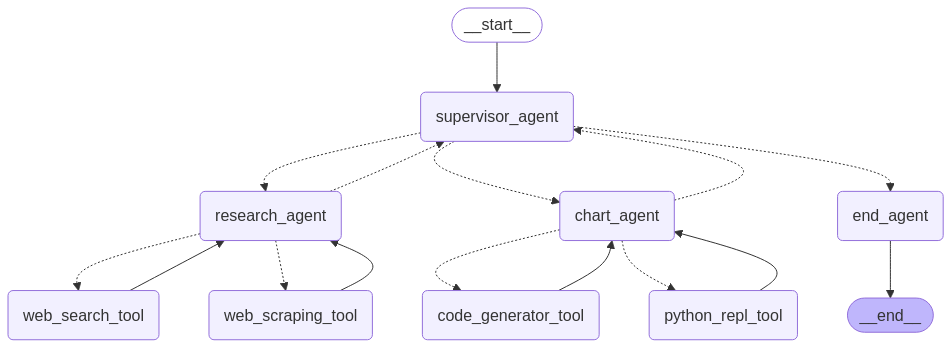

In [20]:
graph = StateGraph(AgentState)
graph.add_node("supervisor_agent", supervisor_agent)
graph.add_node("research_agent", research_agent)
graph.add_node("chart_agent", chart_agent)
graph.add_node("end_agent", end_agent)
graph.add_node("web_search_tool", web_search_tool)
graph.add_node("web_scraping_tool", web_scraping_tool)
graph.add_node("code_generator_tool", code_generator_tool)
graph.add_node("python_repl_tool", python_repl_tool)

#Supervisor Agent
graph.add_edge(START, "supervisor_agent")
graph.add_conditional_edges("supervisor_agent",
    after_supervisor_agent_router,
    ["research_agent", "chart_agent", "end_agent"]
)

#Research Agent
graph.add_conditional_edges("research_agent",
    after_research_agent_router,
    ["web_search_tool", "web_scraping_tool", "supervisor_agent"]
)
graph.add_edge("web_search_tool", "research_agent")
graph.add_edge("web_scraping_tool", "research_agent")

#Chart Agent
graph.add_conditional_edges("chart_agent",
    after_chart_agent_router,
    ["code_generator_tool", "python_repl_tool", "supervisor_agent"]
)
graph.add_edge("code_generator_tool", "chart_agent")
graph.add_edge("python_repl_tool", "chart_agent")

graph.add_edge("end_agent", END)

final_graph = graph.compile()


from IPython.display import Image, display
display(Image(final_graph.get_graph().draw_mermaid_png()))




['Supervisor agent performed the action: research_agent']
The user query is about the current stock price trends of Amazon. Since both the actions_performed and combined_content are empty, it indicates that no research has been conducted yet. Therefore, the next step is to initiate the research agent to gather the necessary information about Amazon's stock price trends.
['Research agent performed the action: web_search_tool']
Since this is the first action and no URLs have been obtained yet, I will use the web_search_tool to gather a list of URLs that provide information on the current stock price trends of Amazon. This will allow us to gather the necessary data to generate a chart on Amazon's stock price trends.
['Research agent performed the action: web_scraping_tool']
Since URLs have been obtained from the web search tool but not yet scraped, the next logical step is to use the web_scraping_tool. This will allow us to extract relevant information about Amazon's current stock price t

Python REPL can execute arbitrary code. Use with caution.


['Chart agent performed the action: python_repl_tool']
The code to generate the chart has been provided by the code_generator_tool. The next step is to execute this code using the python_repl_tool to generate the actual chart. This will allow us to visually assess the data and determine if the chart is satisfactory.


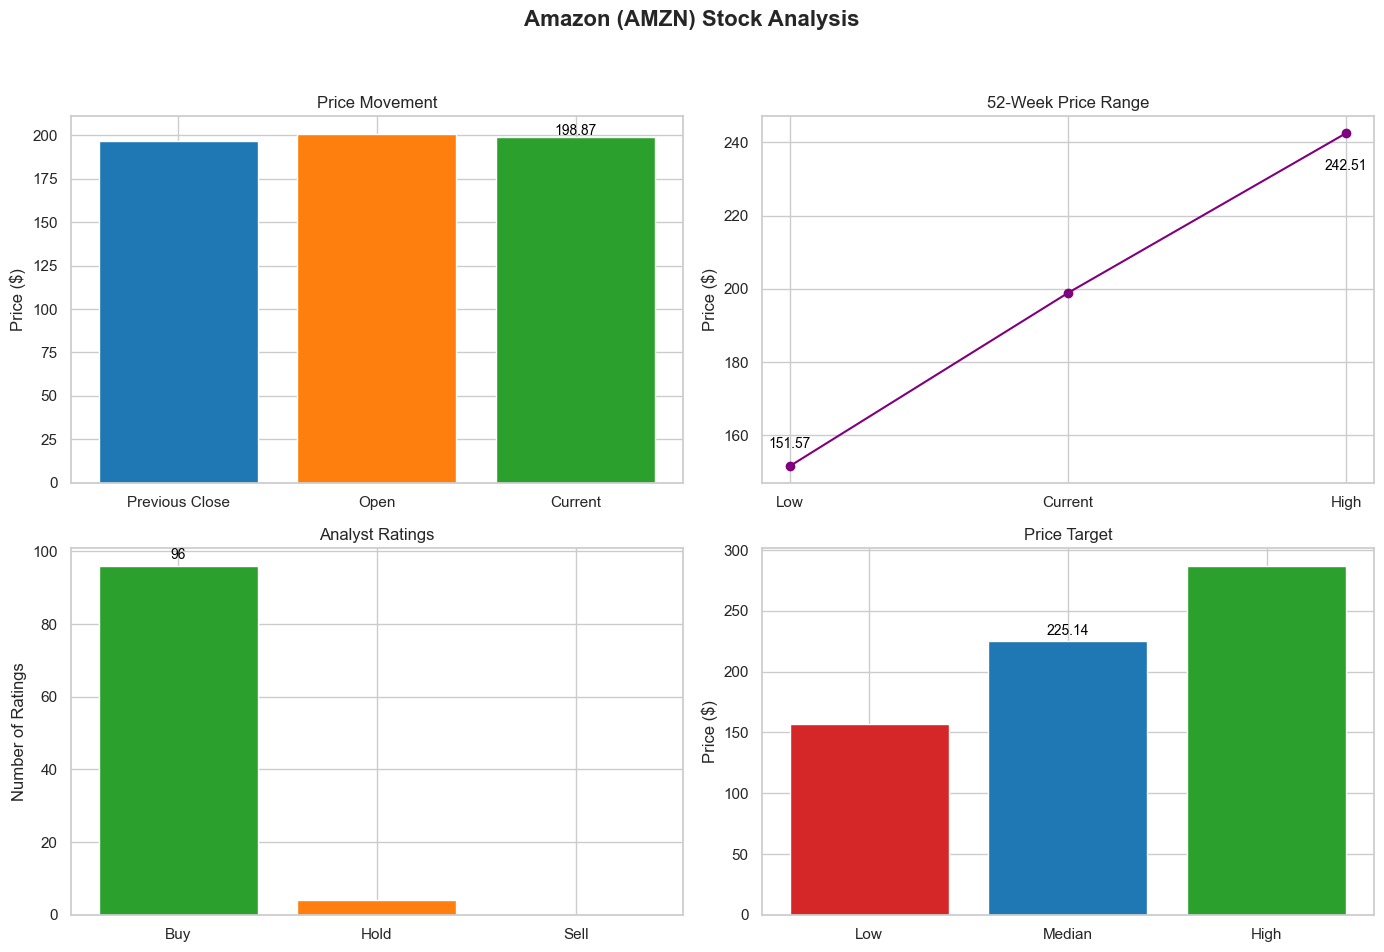

['Chart agent performed the action: DONE']
The chart generated provides a comprehensive visual analysis of Amazon's stock data, including price movement, 52-week range, analyst ratings, and price targets. Each subplot is clearly labeled and annotated, making it easy to interpret the data. The use of different colors for different data points enhances readability. The chart effectively summarizes the key financial metrics and analyst opinions, making it a valuable tool for stakeholders to understand Amazon's stock performance. Therefore, the chart is good enough to be used, and no further actions are needed.
['Supervisor agent performed the action: DONE']
The task is complete as both the research agent and the chart agent have successfully performed their respective tasks. The research agent has gathered comprehensive information about Amazon's current stock price trends, including key financial metrics and analyst ratings. The chart agent has utilized this information to generate a det

In [21]:
for event in final_graph.stream({"query": "What is the current stock price trends of Amazon"}):
    if 'supervisor_agent' in event:
        print("================================================")
        actions_performed = event["supervisor_agent"]["actions_performed"]
        reasoning = event["supervisor_agent"]["supervisor_output"].reasoning
        print(actions_performed)
        print("================================================")
        print(reasoning)
        print("================================================")
    
    if 'research_agent' in event:
        print("================================================")
        actions_performed = event["research_agent"]["actions_performed"]
        print(actions_performed)
        print("================================================")
        reasoning = event["research_agent"]["research_agent_output"].reasoning
        print(reasoning)
        print("================================================")
    
    if 'chart_agent' in event:
        print("================================================")
        actions_performed = event["chart_agent"]["actions_performed"]
        print(actions_performed)
        print("================================================")
        reasoning = event["chart_agent"]["chart_agent_output"].reasoning
        print(reasoning)
        print("================================================")
    
        